In [6]:
# =======================
# 1. Install & Import
# =======================
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [7]:
# =======================
# 2. Dataset Paths
# =======================
train_dir = r"C:\Users\Hp\Desktop\dataset\margeDataset\train"
val_dir   = r"C:\Users\Hp\Desktop\dataset\margeDataset\valid"
test_dir  = r"C:\Users\Hp\Desktop\dataset\margeDataset\test"

# =======================
# 3. Data Generators
# =======================
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_gen.num_classes
class_names = list(train_gen.class_indices.keys())
print("✅ Found classes:", class_names)

Found 20597 images belonging to 20 classes.
Found 5885 images belonging to 20 classes.
Found 2943 images belonging to 20 classes.
✅ Found classes: ['Aair', 'Boal', 'Chapila', 'Foli', 'Ilish', 'KalBaush', 'Katla', 'Koi', 'Magur', 'Mrigel', 'Pabda', 'Pangas', 'Puti', 'Rui', 'Shol', 'SorPuti', 'Taki', 'Tarabaim', 'Telapiya', 'Tengra']


In [8]:
# =======================
# 6. Show Image Counts (Before & After Augmentation)
# =======================

def count_images_in_dir(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        for f in files:
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                count += 1
    return count

train_count_before = count_images_in_dir(train_dir)
val_count_before   = count_images_in_dir(val_dir)
test_count_before  = count_images_in_dir(test_dir)

print("\n===============================")
print("📸 IMAGE COUNT SUMMARY")
print("===============================")
print(f"Original Training images:   {train_count_before}")
print(f"Original Validation images: {val_count_before}")
print(f"Original Testing images:    {test_count_before}")
print("-------------------------------")
print(f"Train Generator samples:    {train_gen.samples}")
print(f"Val Generator samples:      {val_gen.samples}")
print(f"Test Generator samples:     {test_gen.samples}")


📸 IMAGE COUNT SUMMARY
Original Training images:   20597
Original Validation images: 5885
Original Testing images:    2943
-------------------------------
Train Generator samples:    20597
Val Generator samples:      5885
Test Generator samples:     2943


In [9]:
# =======================
# 5. Saving Paths for Laptop
# =======================
base_dir = r"C:\Users\Hp\Desktop\mobilenetv2"
os.makedirs(base_dir, exist_ok=True)

model_path = os.path.join(base_dir, "mobilenetv2_best.h5")
final_model_path = os.path.join(base_dir, "mobilenetv2_final.h5")
log_path = os.path.join(base_dir, "mobilenetv2_training_log.csv")
history_path = os.path.join(base_dir, "history.pkl")

In [10]:
# =======================
# 6. Build or Load Model
# =======================
if os.path.exists(model_path):
    print("🔹 Loading previous best model...")
    model = load_model(model_path)
else:
    print("🔹 Building new MobileNetV2 model...")

    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

model.summary()

🔹 Building new MobileNetV2 model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,591,060 (9.88 MB)

 Trainable params: 333,076 (1.27 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# =======================
# 7. Train (Phase 1)
# =======================
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

csv_logger = CSVLogger(log_path, append=True)

checkpoint = ModelCheckpoint(
    model_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=[early_stop, csv_logger, checkpoint]
)


c:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3640 - loss: 2.1617
Epoch 1: val_loss improved from None to 0.70022, saving model to C:\Users\Hp\Desktop\mobilenetv2\mobilenetv2_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1111s 2s/step - accuracy: 0.5386 - loss: 1.5606 - val_accuracy: 0.8243 - val_loss: 0.7002
Epoch 2/25
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7563 - loss: 0.8069
Epoch 2: val_loss improved from 0.70022 to 0.44922, saving model to C:\Users\Hp\Desktop\mobilenetv2\mobilenetv2_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 980s 2s/step - accuracy: 0.7839 - loss: 0.7266 - val_accuracy: 0.8761 - val_loss: 0.4492
Epoch 3/25
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8303 - loss: 0.5789
Epoch 3: val_loss improved from 0.44922 to 0.34093, saving model to C:\Users\Hp\Desktop\mobilenetv2\mobilenetv2_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1232s 2s/step - accuracy: 0.8436 - loss: 0.5326 - val_accuracy: 0.9105 - val_loss: 0.3409
Epoch 4/25
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8694 - loss: 0.4438
Epoch 4: val_loss improved from 0.34093 to 0.29371, saving model to C:\Users\Hp\Desktop\mobilenetv2\mobilenetv2_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1127s 2s/step - accuracy: 0.8728 - loss: 0.4250 - val_accuracy: 0.9167 - val_loss: 0.2937
Epoch 5/25
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8879 - loss: 0.3729
Epoch 5: val_loss improved from 0.29371 to 0.25877, saving model to C:\Users\Hp\Desktop\mobilenetv2\mobilenetv2_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1147s 2s/step - accuracy: 0.8905 - loss: 0.3614 - val_accuracy: 0.9266 - val_loss: 0.2588
Epoch 6/25
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9026 - loss: 0.3301
Epoch 6: val_loss improved from 0.25877 to 0.23390, saving model to C:\Users\Hp\Desktop\mobilenetv2\mobilenetv2_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1299s 2s/step - accuracy: 0.9043 - loss: 0.3194 - val_accuracy: 0.9325 - val_loss: 0.2339
Epoch 7/25
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9099 - loss: 0.2925
Epoch 7: val_loss improved from 0.23390 to 0.20808, saving model to C:\Users\Hp\Desktop\mobilenetv2\mobilenetv2_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1265s 2s/step - accuracy: 0.9144 - loss: 0.2853 - val_accuracy: 0.9414 - val_loss: 0.2081
Epoch 8/25
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9227 - loss: 0.2581
Epoch 8: val_loss improved from 0.20808 to 0.19427, saving model to C:\Users\Hp\Desktop\mobilenetv2\mobilenetv2_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1310s 2s/step - accuracy: 0.9235 - loss: 0.2561 - val_accuracy: 0.9456 - val_loss: 0.1943
Epoch 9/25
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9249 - loss: 0.2410
Epoch 9: val_loss improved from 0.19427 to 0.18028, saving model to C:\Users\Hp\Desktop\mobilenetv2\mobilenetv2_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1341s 2s/step - accuracy: 0.9275 - loss: 0.2350 - val_accuracy: 0.9482 - val_loss: 0.1803
Epoch 10/25
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9359 - loss: 0.2156
Epoch 10: val_loss improved from 0.18028 to 0.17997, saving model to C:\Users\Hp\Desktop\mobilenetv2\mobilenetv2_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1164s 2s/step - accuracy: 0.9362 - loss: 0.2141 - val_accuracy: 0.9449 - val_loss: 0.1800
Epoch 11/25
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9395 - loss: 0.2036
Epoch 11: val_loss improved from 0.17997 to 0.16556, saving model to C:\Users\Hp\Desktop\mobilenetv2\mobilenetv2_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1229s 2s/step - accuracy: 0.9397 - loss: 0.2019 - val_accuracy: 0.9506 - val_loss: 0.1656
Epoch 12/25
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9443 - loss: 0.1893
Epoch 12: val_loss improved from 0.16556 to 0.15558, saving model to C:\Users\Hp\Desktop\mobilenetv2\mobilenetv2_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1149s 2s/step - accuracy: 0.9437 - loss: 0.1861 - val_accuracy: 0.9516 - val_loss: 0.1556
Epoch 13/25
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9438 - loss: 0.1766
Epoch 13: val_loss improved from 0.15558 to 0.14605, saving model to C:\Users\Hp\Desktop\mobilenetv2\mobilenetv2_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 995s 2s/step - accuracy: 0.9445 - loss: 0.1754 - val_accuracy: 0.9577 - val_loss: 0.1460
Epoch 14/25
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9492 - loss: 0.1671
Epoch 14: val_loss improved from 0.14605 to 0.14016, saving model to C:\Users\Hp\Desktop\mobilenetv2\mobilenetv2_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1161s 2s/step - accuracy: 0.9496 - loss: 0.1656 - val_accuracy: 0.9582 - val_loss: 0.1402
Epoch 15/25
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9511 - loss: 0.1569
Epoch 15: val_loss improved from 0.14016 to 0.13277, saving model to C:\Users\Hp\Desktop\mobilenetv2\mobilenetv2_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1063s 2s/step - accuracy: 0.9515 - loss: 0.1566 - val_accuracy: 0.9616 - val_loss: 0.1328
Epoch 16/25
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9559 - loss: 0.1482
Epoch 16: val_loss improved from 0.13277 to 0.11561, saving model to C:\Users\Hp\Desktop\mobilenetv2\mobilenetv2_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1075s 2s/step - accuracy: 0.9549 - loss: 0.1502 - val_accuracy: 0.9670 - val_loss: 0.1156
Epoch 17/25
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9555 - loss: 0.1442
Epoch 17: val_loss did not improve from 0.11561
644/644 ━━━━━━━━━━━━━━━━━━━━ 1089s 2s/step - accuracy: 0.9550 - loss: 0.1439 - val_accuracy: 0.9633 - val_loss: 0.1260
Epoch 18/25
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9571 - loss: 0.1362
Epoch 18: val_loss did not improve from 0.11561
644/644 ━━━━━━━━━━━━━━━━━━━━ 1129s 2s/step - accuracy: 0.9564 - loss: 0.1402 - val_accuracy: 0.9621 - val_loss: 0.1232
Epoch 19/25
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9616 - loss: 0.1275
Epoch 19: val_loss improved from 0.11561 to 0.10971, saving model to C:\Users\Hp\Desktop\mobilenetv2\mobilenetv2_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1281s 2s/step - accuracy: 0.9627 - loss: 0.1254 - val_accuracy: 0.9682 - val_loss: 0.1097
Epoch 20/25
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9612 - loss: 0.1274
Epoch 20: val_loss did not improve from 0.10971
644/644 ━━━━━━━━━━━━━━━━━━━━ 1210s 2s/step - accuracy: 0.9618 - loss: 0.1256 - val_accuracy: 0.9655 - val_loss: 0.1167
Epoch 21/25
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9636 - loss: 0.1191
Epoch 21: val_loss did not improve from 0.10971
644/644 ━━━━━━━━━━━━━━━━━━━━ 1205s 2s/step - accuracy: 0.9640 - loss: 0.1163 - val_accuracy: 0.9658 - val_loss: 0.1101
Epoch 22/25
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9629 - loss: 0.1169
Epoch 22: val_loss improved from 0.10971 to 0.10857, saving model to C:\Users\Hp\Desktop\mobilenetv2\mobilenetv2_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1183s 2s/step - accuracy: 0.9654 - loss: 0.1149 - val_accuracy: 0.9672 - val_loss: 0.1086
Epoch 23/25
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9642 - loss: 0.1125
Epoch 23: val_loss did not improve from 0.10857
644/644 ━━━━━━━━━━━━━━━━━━━━ 1228s 2s/step - accuracy: 0.9657 - loss: 0.1096 - val_accuracy: 0.9653 - val_loss: 0.1092
Epoch 24/25
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9680 - loss: 0.1060
Epoch 24: val_loss did not improve from 0.10857
644/644 ━━━━━━━━━━━━━━━━━━━━ 1265s 2s/step - accuracy: 0.9675 - loss: 0.1081 - val_accuracy: 0.9679 - val_loss: 0.1106
Epoch 25/25
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9700 - loss: 0.0968
Epoch 25: val_loss improved from 0.10857 to 0.10279, saving model to C:\Users\Hp\Desktop\mobilenetv2\mobilenetv2_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1191s 2s/step - accuracy: 0.9702 - loss: 0.0987 - val_accuracy: 0.9713 - val_loss: 0.1028


NameError: name 'pickle' is not defined

In [ ]:
# Save history
import pickle
with open(history_path, "wb") as f:
    pickle.dump(history.history, f)

print("✅ Phase 1 training done.")

In [12]:
# =======================
# 8. Fine-tuning (Phase 2)
# =======================
print("🔹 Fine-tuning last 40 layers of MobileNetV2...")
base_model.trainable = True
for layer in base_model.layers[:-40]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop, csv_logger, checkpoint]
)


🔹 Fine-tuning last 40 layers of MobileNetV2...
Epoch 1/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8392 - loss: 0.5080
Epoch 1: val_loss did not improve from 0.10279
644/644 ━━━━━━━━━━━━━━━━━━━━ 1364s 2s/step - accuracy: 0.8803 - loss: 0.3749 - val_accuracy: 0.9648 - val_loss: 0.1044
Epoch 2/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9311 - loss: 0.2103
Epoch 2: val_loss improved from 0.10279 to 0.09364, saving model to C:\Users\Hp\Desktop\mobilenetv2\mobilenetv2_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1301s 2s/step - accuracy: 0.9384 - loss: 0.1916 - val_accuracy: 0.9684 - val_loss: 0.0936
Epoch 3/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9531 - loss: 0.1444
Epoch 3: val_loss improved from 0.09364 to 0.08118, saving model to C:\Users\Hp\Desktop\mobilenetv2\mobilenetv2_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1229s 2s/step - accuracy: 0.9548 - loss: 0.1405 - val_accuracy: 0.9749 - val_loss: 0.0812
Epoch 4/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9629 - loss: 0.1156
Epoch 4: val_loss improved from 0.08118 to 0.07415, saving model to C:\Users\Hp\Desktop\mobilenetv2\mobilenetv2_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1232s 2s/step - accuracy: 0.9634 - loss: 0.1153 - val_accuracy: 0.9782 - val_loss: 0.0742
Epoch 5/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9682 - loss: 0.0946
Epoch 5: val_loss improved from 0.07415 to 0.06926, saving model to C:\Users\Hp\Desktop\mobilenetv2\mobilenetv2_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1234s 2s/step - accuracy: 0.9698 - loss: 0.0923 - val_accuracy: 0.9793 - val_loss: 0.0693
Epoch 6/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9742 - loss: 0.0791
Epoch 6: val_loss improved from 0.06926 to 0.06438, saving model to C:\Users\Hp\Desktop\mobilenetv2\mobilenetv2_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1232s 2s/step - accuracy: 0.9749 - loss: 0.0783 - val_accuracy: 0.9805 - val_loss: 0.0644
Epoch 7/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9766 - loss: 0.0716
Epoch 7: val_loss improved from 0.06438 to 0.05876, saving model to C:\Users\Hp\Desktop\mobilenetv2\mobilenetv2_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1227s 2s/step - accuracy: 0.9770 - loss: 0.0689 - val_accuracy: 0.9827 - val_loss: 0.0588
Epoch 8/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9810 - loss: 0.0615
Epoch 8: val_loss did not improve from 0.05876
644/644 ━━━━━━━━━━━━━━━━━━━━ 1216s 2s/step - accuracy: 0.9803 - loss: 0.0613 - val_accuracy: 0.9810 - val_loss: 0.0608
Epoch 9/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9820 - loss: 0.0571
Epoch 9: val_loss improved from 0.05876 to 0.05532, saving model to C:\Users\Hp\Desktop\mobilenetv2\mobilenetv2_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1297s 2s/step - accuracy: 0.9826 - loss: 0.0570 - val_accuracy: 0.9840 - val_loss: 0.0553
Epoch 10/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9858 - loss: 0.0459
Epoch 10: val_loss improved from 0.05532 to 0.05066, saving model to C:\Users\Hp\Desktop\mobilenetv2\mobilenetv2_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1090s 2s/step - accuracy: 0.9853 - loss: 0.0464 - val_accuracy: 0.9849 - val_loss: 0.0507


In [13]:
# =======================
# 9. Evaluate on Test Data
# =======================
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"\n✅ Testing Accuracy : {test_acc*100:.2f}%")
print(f"✅ Testing Loss     : {test_loss:.4f}")



92/92 ━━━━━━━━━━━━━━━━━━━━ 74s 798ms/step - accuracy: 0.9834 - loss: 0.0511

✅ Testing Accuracy : 98.34%
✅ Testing Loss     : 0.0511


In [14]:
# =======================
# 10. Evaluate on valid Data
# =======================
val_loss, val_acc = model.evaluate(val_gen, verbose=1)
print(f"\n✅ validation Accuracy : {val_acc*100:.2f}%")
print(f"✅ validation Loss     : {val_loss:.4f}")

184/184 ━━━━━━━━━━━━━━━━━━━━ 144s 780ms/step - accuracy: 0.9849 - loss: 0.0507

✅ validation Accuracy : 98.49%
✅ validation Loss     : 0.0507


In [15]:
# =======================
# 11. Evaluate on Train Data
# =======================
train_loss, train_acc = model.evaluate(train_gen, verbose=1)
print(f"\n✅ train Accuracy : {train_acc*100:.2f}%")
print(f"✅ train Loss     : {train_loss:.4f}")

644/644 ━━━━━━━━━━━━━━━━━━━━ 738s 1s/step - accuracy: 0.9964 - loss: 0.0146

✅ train Accuracy : 99.64%
✅ train Loss     : 0.0146


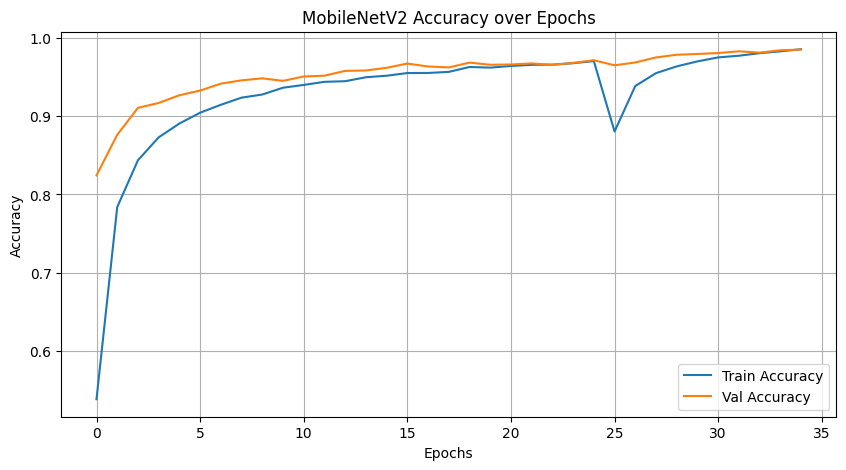

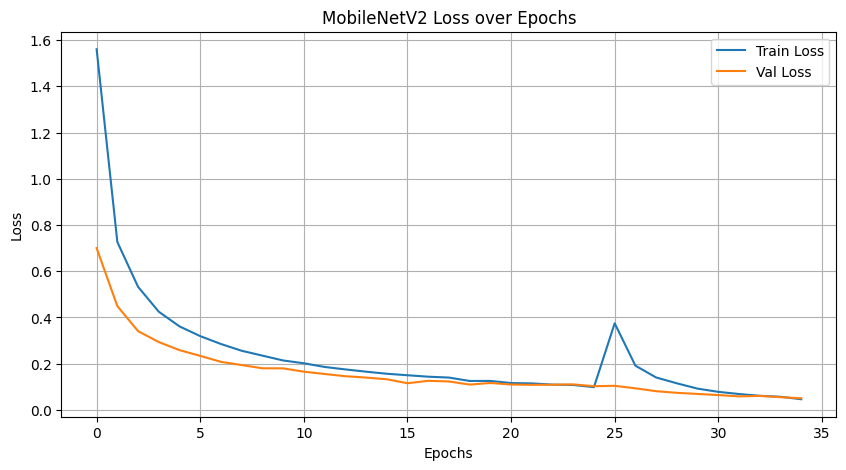

In [16]:
# =======================
# 12. Plot Training History
# =======================
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'] + fine_tune_history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'], label='Val Accuracy')
plt.title('MobileNetV2 Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'] + fine_tune_history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + fine_tune_history.history['val_loss'], label='Val Loss')
plt.title('MobileNetV2 Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

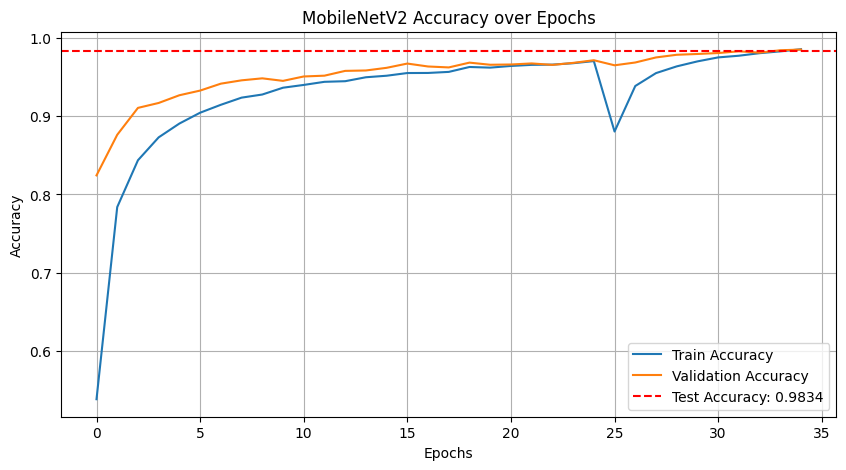

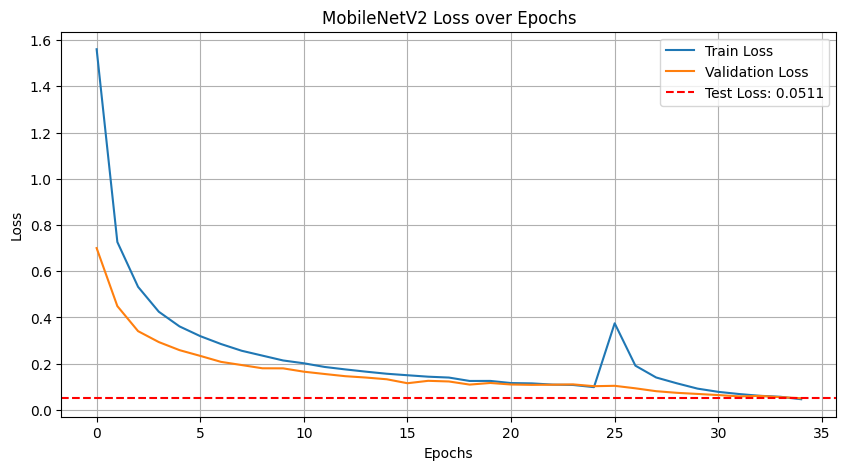

In [17]:
# =======================
# 13. Plot Training + Validation + Test Accuracy
# =======================
plt.figure(figsize=(10,5))
# Combine phase1 + phase2 history
train_acc = history.history['accuracy'] + fine_tune_history.history['accuracy']
val_acc   = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']

plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')

# Test accuracy line
plt.axhline(y=test_acc, color='r', linestyle='--', label=f'Test Accuracy: {test_acc:.4f}')

plt.title('MobileNetV2 Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
# Combine phase1 + phase2 loss
train_loss = history.history['loss'] + fine_tune_history.history['loss']
val_loss   = history.history['val_loss'] + fine_tune_history.history['val_loss']

plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')

# Test loss line
plt.axhline(y=test_loss, color='r', linestyle='--', label=f'Test Loss: {test_loss:.4f}')

plt.title('MobileNetV2 Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
# =======================
# 14. Predictions & Evaluation
# =======================
y_pred = model.predict(test_gen, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

print("\n📊 Classification Report:\n")
print(classification_report(
    y_true,
    y_pred_classes,
    target_names=class_names,
    digits=4
))

92/92 ━━━━━━━━━━━━━━━━━━━━ 75s 792ms/step

📊 Classification Report:

              precision    recall  f1-score   support

        Aair     0.9731    0.9837    0.9784       184
        Boal     1.0000    0.9645    0.9819       169
     Chapila     1.0000    0.9355    0.9667        62
        Foli     0.9545    0.9692    0.9618        65
       Ilish     0.9508    1.0000    0.9748       116
    KalBaush     0.9510    0.9898    0.9700        98
       Katla     0.9781    0.9676    0.9728       185
         Koi     0.9789    0.9789    0.9789        95
       Magur     0.9865    0.9865    0.9865        74
      Mrigel     0.9894    1.0000    0.9947       186
       Pabda     0.9849    1.0000    0.9924       196
      Pangas     0.9903    0.9533    0.9714       107
        Puti     1.0000    0.9828    0.9913       174
         Rui     0.9731    0.9844    0.9787       257
        Shol     0.9702    1.0000    0.9849       163
     SorPuti     1.0000    0.9787    0.9892        47
        Taki

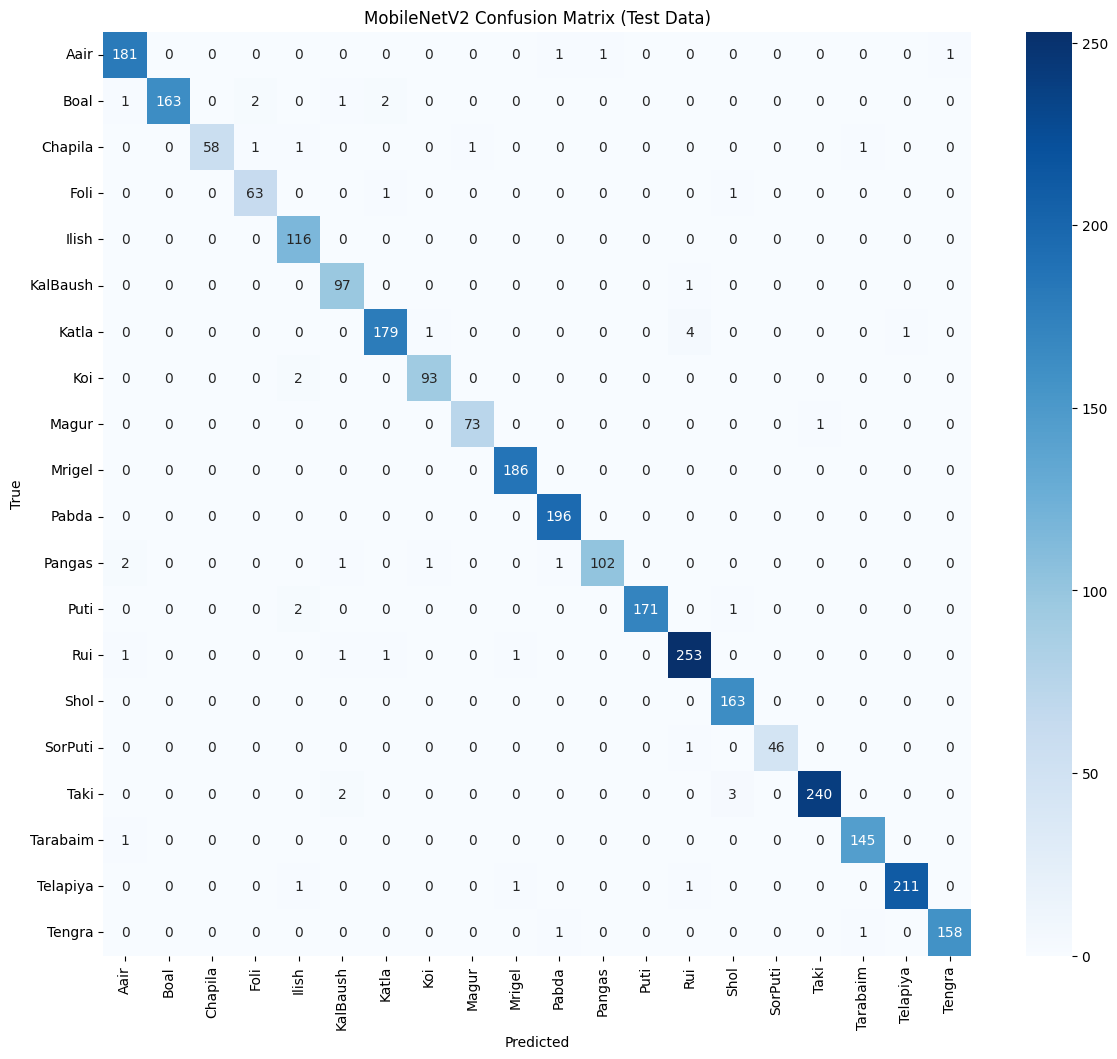

In [19]:
# =======================
# 15. Confusion Matrix
# =======================
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(14,12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("MobileNetV2 Confusion Matrix (Test Data)")
plt.show()


📊 Per-Class Metrics:

          Precision  Recall  F1-Score
Class                                
Aair         0.9731  0.9837    0.9784
Boal         1.0000  0.9645    0.9819
Chapila      1.0000  0.9355    0.9667
Foli         0.9545  0.9692    0.9618
Ilish        0.9508  1.0000    0.9748
KalBaush     0.9510  0.9898    0.9700
Katla        0.9781  0.9676    0.9728
Koi          0.9789  0.9789    0.9789
Magur        0.9865  0.9865    0.9865
Mrigel       0.9894  1.0000    0.9947
Pabda        0.9849  1.0000    0.9924
Pangas       0.9903  0.9533    0.9714
Puti         1.0000  0.9828    0.9913
Rui          0.9731  0.9844    0.9787
Shol         0.9702  1.0000    0.9849
SorPuti      1.0000  0.9787    0.9892
Taki         0.9959  0.9796    0.9877
Tarabaim     0.9864  0.9932    0.9898
Telapiya     0.9953  0.9860    0.9906
Tengra       0.9937  0.9875    0.9906


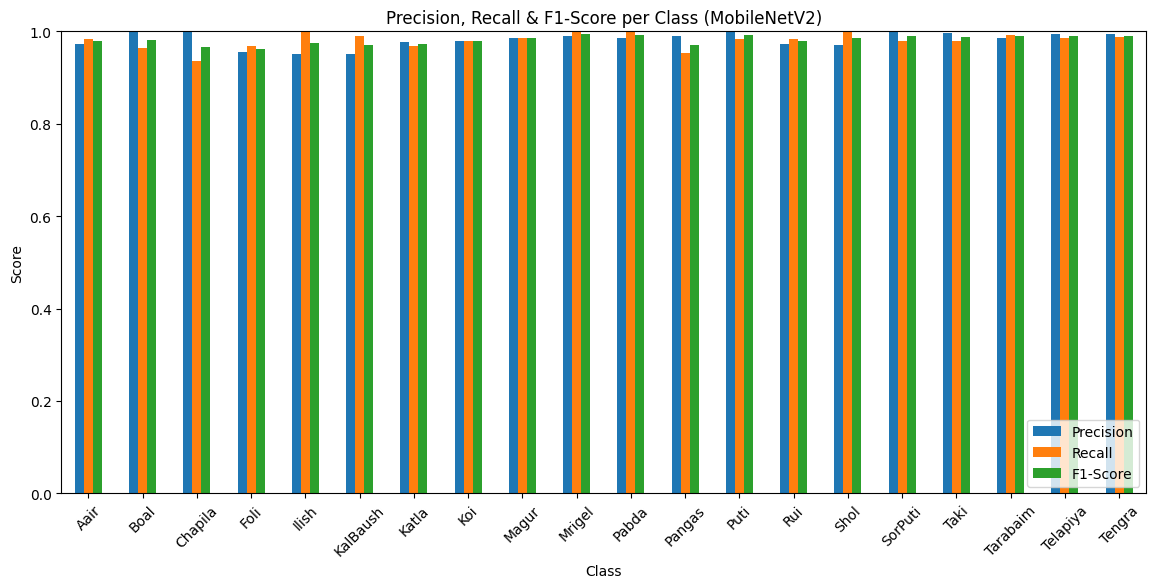

In [20]:
# =======================
# 16. Precision, Recall, F1
# =======================
precision = precision_score(y_true, y_pred_classes, average=None, labels=range(len(class_names)))
recall    = recall_score(y_true, y_pred_classes, average=None, labels=range(len(class_names)))
f1        = f1_score(y_true, y_pred_classes, average=None, labels=range(len(class_names)))

metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}).set_index('Class')

print("\n📊 Per-Class Metrics:\n")
print(metrics_df.round(4))

metrics_df.plot(kind='bar', figsize=(14,6))
plt.title("Precision, Recall & F1-Score per Class (MobileNetV2)")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()

In [21]:
# =======================
# 17. Save JSON Summary (For Comparison)
# =======================
results = {
    "dataset": "FishMergedDataset",
    "model": "MobileNetV2",
    "train_acc": float(history.history['accuracy'][-1]),
    "val_acc": float(history.history['val_accuracy'][-1]),
    "test_acc": float(test_acc),
    "precision": float(np.mean(precision)),
    "recall": float(np.mean(recall)),
    "f1": float(np.mean(f1))
}

with open("/kaggle/working/results_mobilenetv2_merged.json", "w") as f:
    json.dump(results, f, indent=4)

print("✅ results_mobilenetv2_merged.json saved successfully!")

✅ results_mobilenetv2_merged.json saved successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


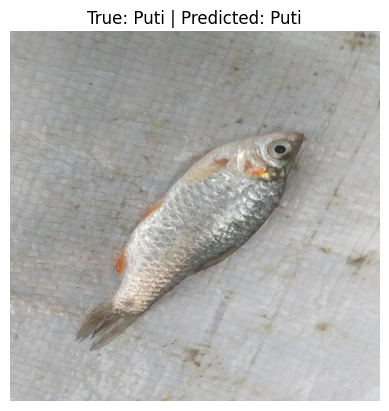

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


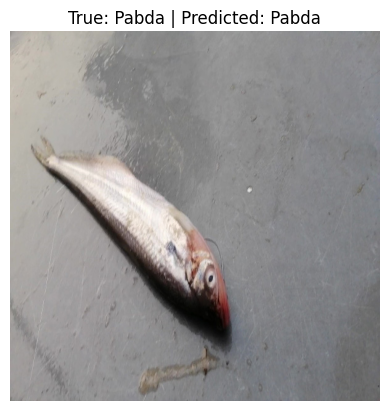

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


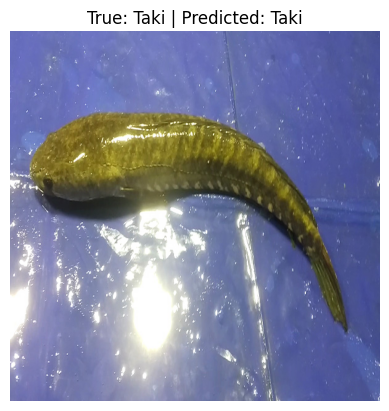

In [22]:
# =======================
# 18. Random Test Predictions
# =======================
def predict_random_image(test_dir, model, class_names, img_size=(224,224)):
    random_class = random.choice(os.listdir(test_dir))
    class_path = os.path.join(test_dir, random_class)
    random_img = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, random_img)

    img = tf.keras.utils.load_img(img_path, target_size=img_size)
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    pred_class = class_names[np.argmax(pred)]
    true_class = random_class

    plt.imshow(tf.keras.utils.load_img(img_path))
    plt.axis("off")
    plt.title(f"True: {true_class} | Predicted: {pred_class}")
    plt.show()

for i in range(3):
    predict_random_image(test_dir, model, class_names)